**NB:** Precomputed predictions can be found in the Excel file `./data/precomputed_predictions.xlsx`

In [1]:
import os, pickle, glob, csv
import prody
import numpy as np
import pandas as pd

In [2]:
import rhapsody as rd

rd.initialSetup()

@> You are running Rhapsody v0.9.7

@> Pre-existing working directory detected: /home/luca/rhapsody
@> Pre-existing classifiers found: /home/luca/rhapsody/default_classifiers-sklearn_v0.21.3
@> Pre-existing EVmutation metrics found.
@> EVmutation folder found: /home/luca/rhapsody/EVmutation_mutation_effects
@> DSSP is installed on the system.
@> Setup complete.


# Analysis of human ROMK variants
Since the structure of human ROMK has not been resolved yet, we will use a homology model from SWISS-MODEL.

In [3]:
from prody import *

pdb_path = 'data/ROMK_homology_model.pdb'
pdb = prody.parsePDB(pdb_path).select('protein')

print(pdb['A'].getResnums())
pdb.getHierView()

@> 10528 atoms and 1 coordinate set(s) were parsed in 0.14s.


[ 38  38  38 ... 365 365 365]


<HierView: Selection 'protein' (4 chains, 1312 residues)>

## RHAPSODY predictions
We will compute predictions with different environment models and with/without EVmutation feature included in the classifier. We will refer to the Rhapsody classifier without EVmutation feature as "classic".

In [4]:
all_preds = {}

if os.path.isfile('local/all_preds.pkl'):
    all_preds = pickle.load(open('local/all_preds.pkl', 'rb'))
    print('Precomputed predictions imported.')
else:
    if not os.path.isdir('local'):
        os.mkdir('local')
    for mode in ['classic', 'EVmutation']:
        for env in ['chain', 'reduced', 'sliced']:
            case = f'{mode}-{env}'
            folder = os.path.join('local', case)
            if os.path.isdir(folder):
                pickle_file = os.path.join(folder, 'rhapsody-pickle.pkl')
                all_preds[case] = pickle.load(open(pickle_file, 'rb'))
                continue
            os.mkdir(folder)
            # run rhapsody
            if mode == 'classic':
                rh = rd.rhapsody('data/pph2-full.txt', query_type='PolyPhen2', 
                                 custom_PDB=pdb, force_env=env)
            else:
                rh = rd.rhapsody('data/pph2-full.txt', query_type='PolyPhen2', 
                                 main_classifier=rd.getDefaultClassifiers()['EVmut'],
                                 custom_PDB=pdb, force_env=env)
            # store files
            all_preds[case] = rh
            for f in glob.glob('rhapsody-*.*'):
                os.rename(f, os.path.join(folder, f))
    pickle.dump(all_preds, open('local/all_preds.pkl', 'wb'))

Precomputed predictions imported.


Since ROMK protein is a tetramer, we expect to obtain better predictions when taking into account all monomers when computing dynamical features. This is accomplished by using "sliced" elastic network models.

In [5]:
rh_ref_classic = all_preds['classic-sliced']
rh_ref_EVmut = all_preds['EVmutation-sliced']

In [6]:
# print saturation mutagenesis table
rd.print_sat_mutagen_figure(
    'local/sat_mutagen-1', rh_ref_classic, fig_width=26, res_interval=(37, 202))
rd.print_sat_mutagen_figure(
    'local/sat_mutagen-2', rh_ref_classic, fig_width=26, res_interval=(202, 367))

# print residue-averaged predictions on PDB structure
mappedPDBs = rh_ref_classic.writePDBs(filename_prefix='local/rhapsody-PDB')

@> Saturation mutagenesis figure saved to local/sat_mutagen-1.png
@> Saturation mutagenesis figure saved to local/sat_mutagen-2.png
@> Predictions written to PDB file local/rhapsody-PDB_custom.pdb


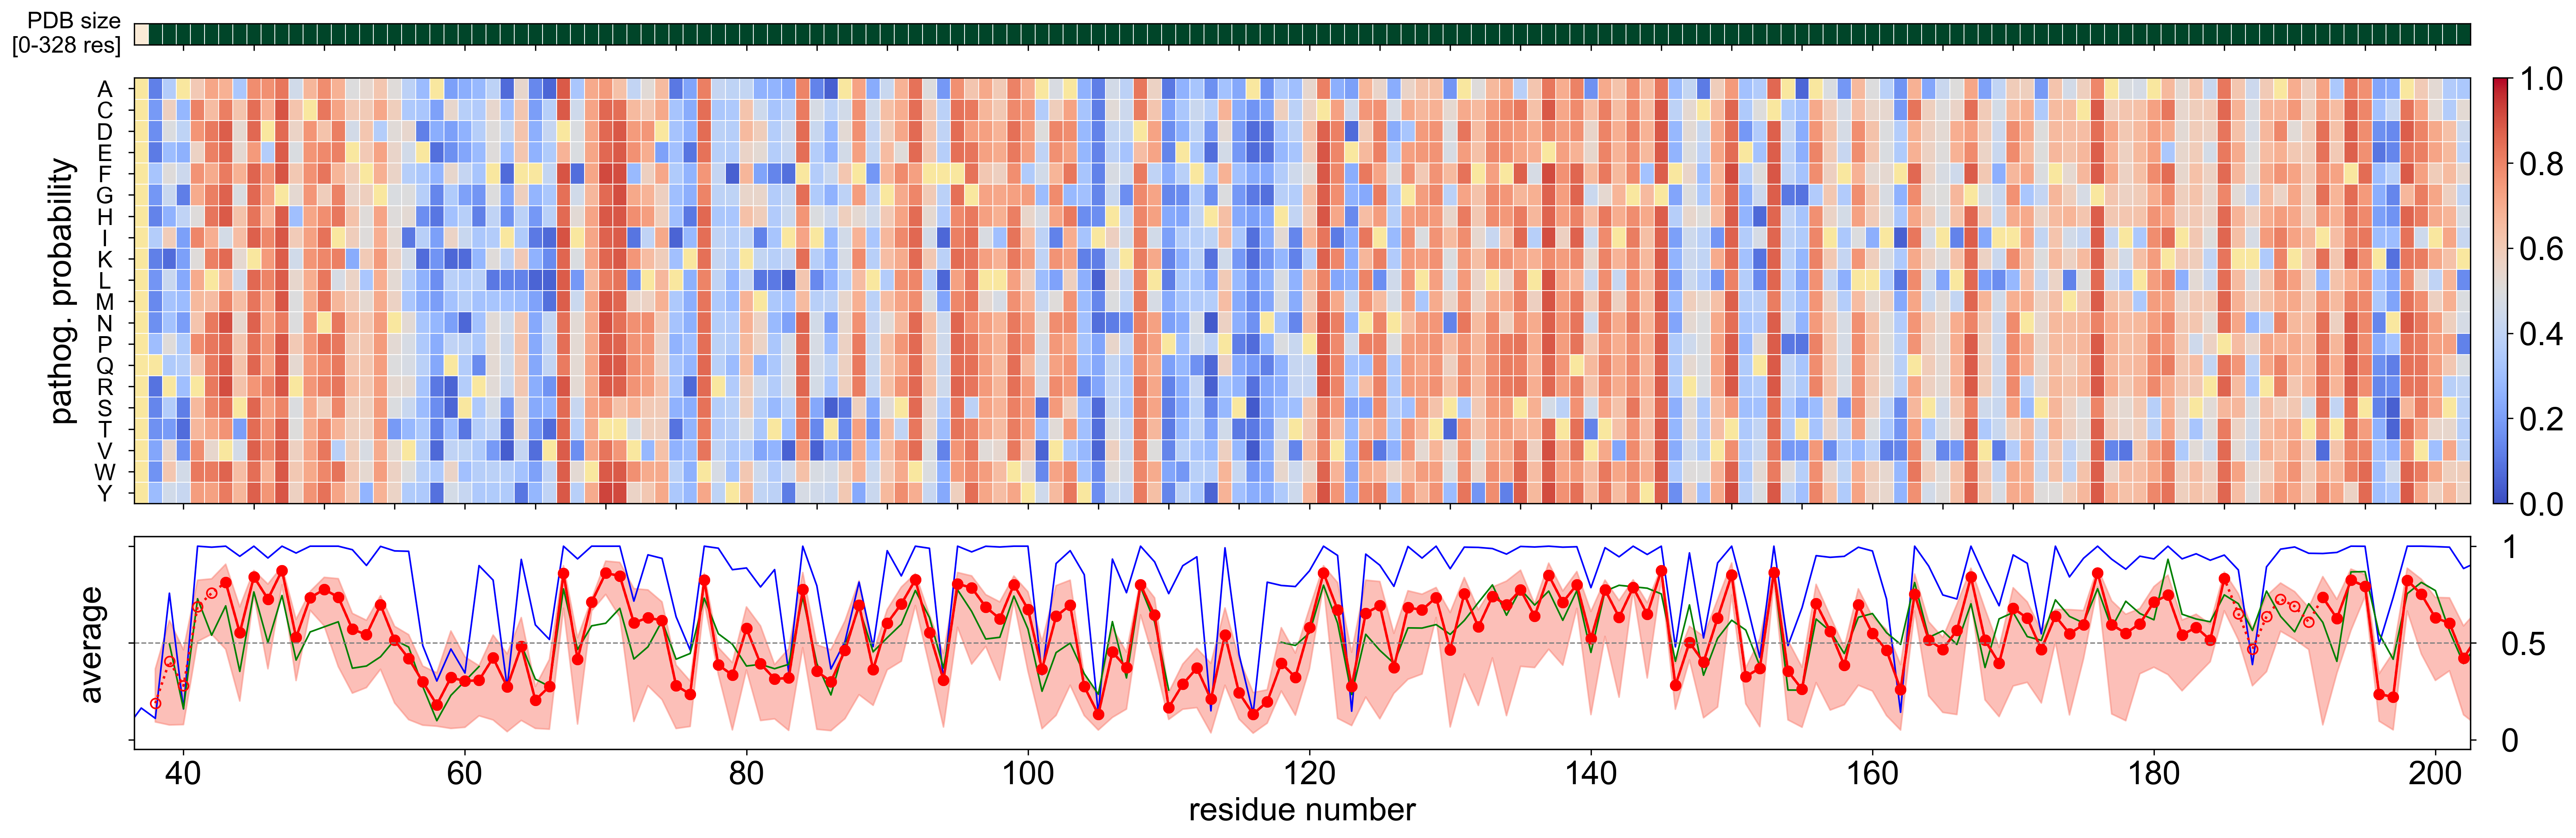

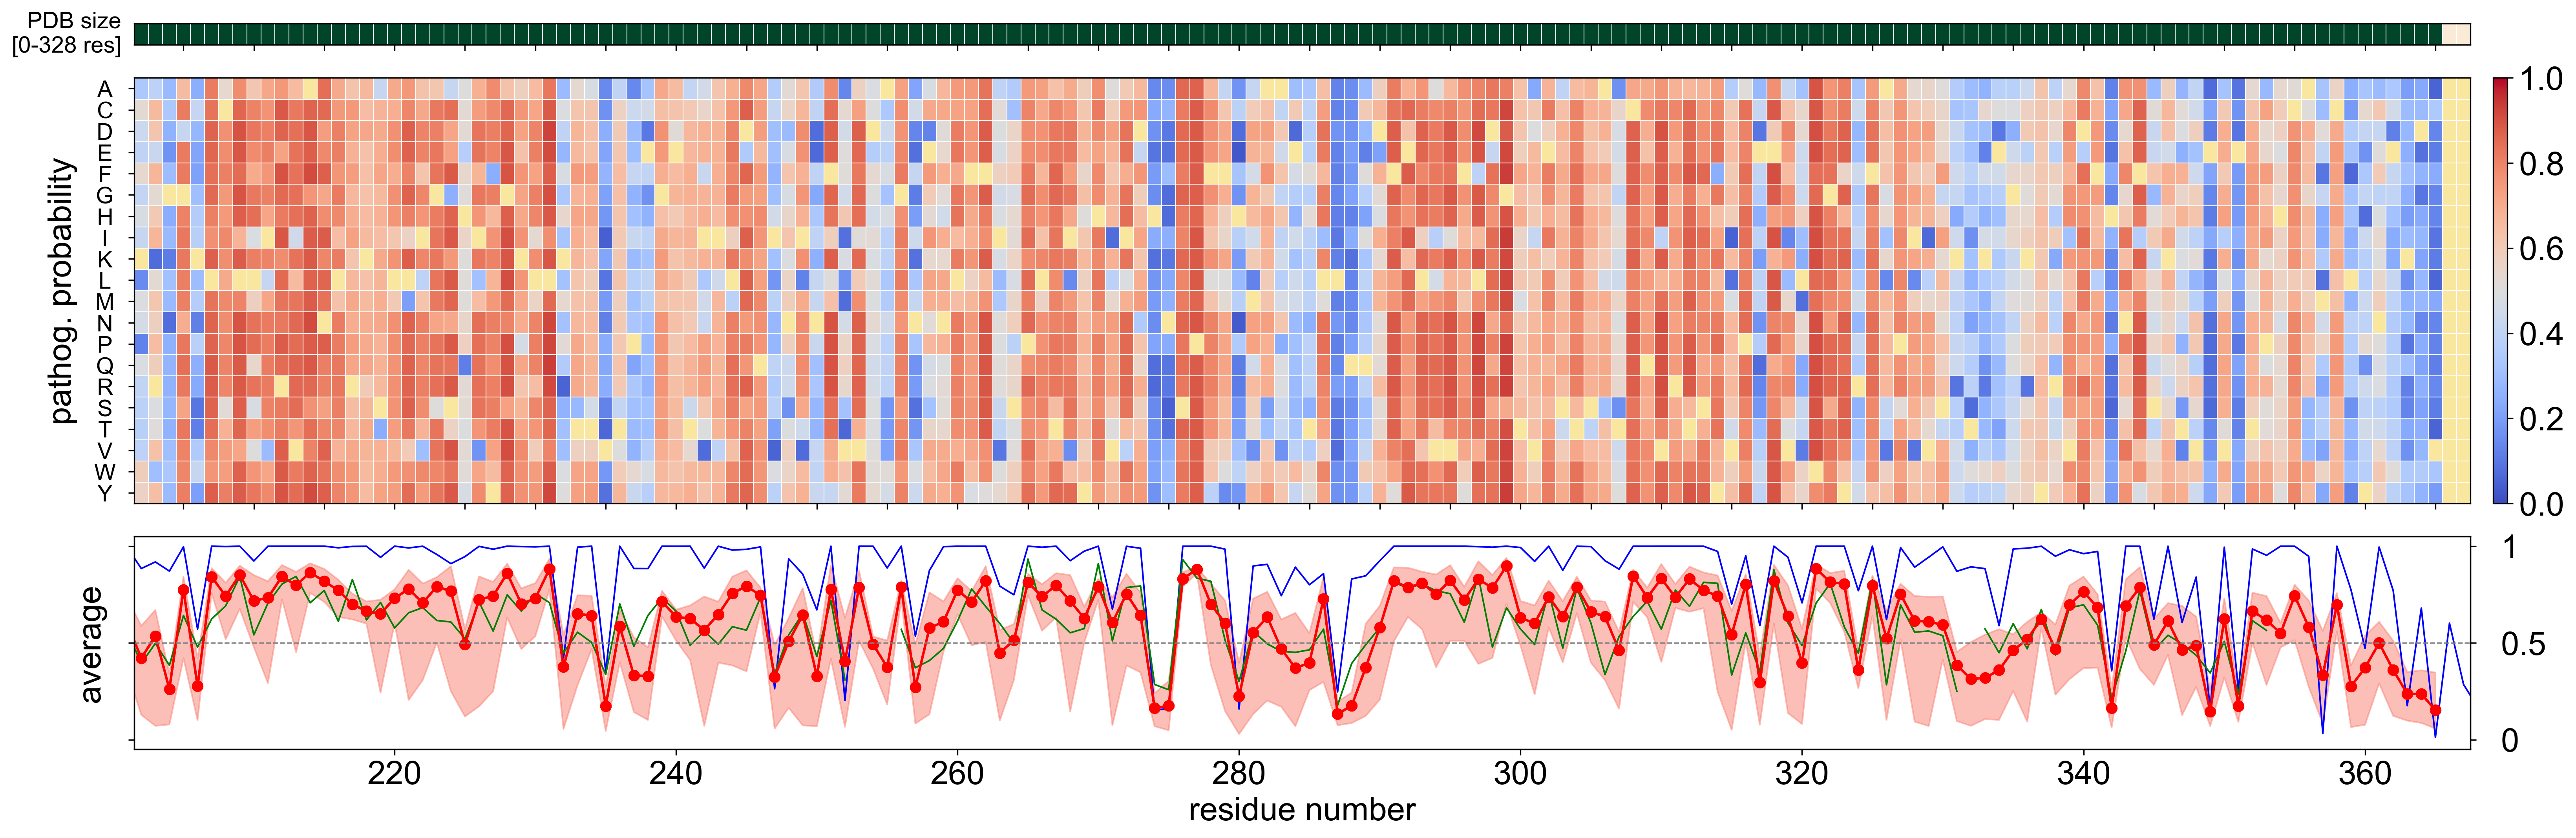

In [7]:
from IPython.core.display import Image, display
display(Image('local/sat_mutagen-1.png', width=900, unconfined=True))
display(Image('local/sat_mutagen-2.png', width=900, unconfined=True))

Rhapsody's output also contains predictions from other two methods, PolyPhen-2 and EVmutation.

In the table below, we show that Rhapsody and EVmutation have more balanced predictions than PolyPhen-2. The latter, in fact, predicts ~77% of all possible ROMK variants to be "deleterious". On the other hand, Rhapsody and EVmutation are unable to provide predictions for, respectively, ~16% and ~23% of variants.

In [8]:
from collections import Counter

table = []
for method in ['classic-sliced', 'EVmutation-sliced', 
               'PolyPhen-2', 'EVmutation']:
    if 'sliced' in method:
        preds = all_preds[method].getPredictions()
        count = Counter(preds['path. class'])
    else:
        preds = all_preds['classic-sliced'].getPredictions()
        count = Counter(preds[f'{method} path. class'])
    # calculate fraction of predictions in each class
    dels = count.get('deleterious', 0) + count.get('prob.delet.', 0)
    neus = count.get('neutral', 0) + count.get('prob.neutral', 0)
    unks = count.get('?', 0)
    n = len(preds)
    if method == 'classic-sliced':
        method = 'Rhapsody'
    elif method == 'EVmutation-sliced':
        method = 'Rhapsody+EVmutation'
    table.append([method, dels/n*100, neus/n*100, unks/n*100])
df_stats = pd.DataFrame(table, columns=['method', 'del. SAVs', 'neu. SAVs', 'no pred.'])
pd.set_option('max_colwidth', 20)
pd.options.display.float_format = '{:,.1f}%'.format
df_stats

,method,del. SAVs,neu. SAVs,no pred.
0,Rhapsody,55.5%,28.4%,16.1%
1,Rhapsody+EVmutation,49.2%,25.4%,25.3%
2,PolyPhen-2,76.5%,23.5%,0.0%
3,EVmutation,49.0%,28.3%,22.8%


## Comparison with experimental results

In [9]:
# import exp. results from file
reader = csv.reader(open('data/experimental_results.csv'))
# translation map for phenotype codes 
exp_map = {
    '-1': 'INC', # increased growth
    '0': 'NEU',  # no growth defect
    '1': 'INT',  # modest growth defect
    '2': 'DEL'   # severe growth defect
}

# rename classifier variants and prediction outputs
cases = list(all_preds.keys())
case_map = {
    'classic-chain': 'R_ch', 'classic-reduced': 'R_rd', 
    'classic-sliced': 'R_sl', 'EVmutation-chain': 'R+E_ch',
    'EVmutation-reduced': 'R+E_rd', 'EVmutation-sliced': 'R+E_sl'}

# fill table with exp. results and relative predictions for
# tested variants
table = []
for i,l in enumerate(reader):
    # skip header
    if i==0:
        continue
        
    # store SAV coordinates, exp. info and group info
    SAV = l[0]
    oSAV = 'P48048 '+l[1] if l[1] else 'P48048 '+SAV
    exp_fitness = exp_map[l[2]]
    group = l[3]
    pred_class = l[4]
    hSAV = f'({l[1][-3:]:3})' if l[1] else ' -'
    row = [SAV, oSAV, hSAV, exp_fitness, group, pred_class]
    
    # store predictions (scores and classes)
    for case in cases:
        rh = all_preds[case].getPredictions(SAV=oSAV)
        row.append(rh['path. prob.'])
        row.append(rh['path. class'])
    
    # store predictions from EVmutation and PolyPhen-2
    rh = rh_ref_classic.getPredictions(SAV=oSAV)
    for method in ['EVmutation', 'PolyPhen-2']:
        row.append(rh[f'{method} score'])
        row.append(rh[f'{method} path. class'])

    table.append(row)

# store table in a dataframe
columns = ['SAV', 'oSAV', 'hSAV', 'exp. fitness', 'group', 'pred.class']
for c in cases:
    columns.extend([f'{case_map[c]} score', case_map[c]])
for c in ['EVmut', 'PP2']:
    columns.extend([f'{c} score', c])
df = pd.DataFrame(table, columns=columns)

# print subset of columns
sel_cols = [c for c in columns if not (c=='oSAV' or c.endswith('score'))]
pd.set_option('max_colwidth', 15)
display(df[sel_cols])

,SAV,hSAV,exp. fitness,group,pred.class,R_ch,R_rd,R_sl,R+E_ch,R+E_rd,R+E_sl,EVmut,PP2
0,140 V M,-,INC,0,pos_control,neutral,deleterious,deleterious,neutral,neutral,neutral,neutral,deleterious
1,80 K M,-,INC,0,pos_control,neutral,deleterious,deleterious,neutral,neutral,neutral,neutral,deleterious
2,342 H S,-,INT,1,GOF,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral
3,65 F L,-,NEU,1,GOF,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral
4,86 T A,-,NEU,1,GOF,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral
5,154 A P,-,DEL,1,GOF,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral
6,94 F L,-,NEU,1,GOF,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral
7,358 C Q,-,DEL,2,del_novel,deleterious,deleterious,deleterious,?,?,?,?,deleterious
8,355 C Q,-,DEL,2,del_novel,deleterious,deleterious,deleterious,?,?,?,?,deleterious
9,361 N C,-,INT,2,del_novel,deleterious,deleterious,deleterious,?,?,?,?,deleterious


## AUROC and other accuracy metrics

In [10]:
class_map = {'neutral': 0, 'prob.neutral': 0, '?': -1,
             'deleterious': 1, 'prob.delet.': 1}
resampling=100

metrics = {}

for INC_label in [-1, 0, 1]:
    
    metrics[INC_label] = {}
    
    # define how to assign binary classification labels, in particular
    # for variants displaying "increased growth" (INC) phenotype
    label_map = {'DEL': 1, 'INT': 1, 'NEU': 0, 'INC': INC_label}
    true_labels = np.array([label_map[x] for x in df['exp. fitness']])

    # compute accuracy metrics
    for method in ['R_sl', 'R+E_sl', 'PP2', 'EVmut']:
        pscore = df[f'{method} score']
        if method == 'EVmut':
            pscore = -pscore
        pclass = np.array([class_map[c] for c in df[method]])
        # select valid predictions and true labels
        sel = np.logical_and(~np.isnan(pscore), true_labels!=-1)
        # compute accuracy metrics
        ds = rd.calcScoreMetrics(true_labels[sel], pscore[sel])
        dc = rd.calcClassMetrics(true_labels[sel], pclass[sel])
        # bootstrapped measures
        dsb = rd.calcScoreMetrics(true_labels[sel], pscore[sel], bootstrap=resampling)
        dcb = rd.calcClassMetrics(true_labels[sel], pclass[sel], bootstrap=resampling)
        metrics[INC_label][method] = {**ds , **dc, **dsb, **dcb}
    
    # for the sake of comparison, we also consider Rhapsody and PolyPhen-2's
    # predictions on the same subset of variants as EVmutation's
    for method in ['R_sl', 'PP2']:
        pscore = df[f'{method} score']
        pclass = np.array([class_map[c] for c in df[method]])
        # ignore SAVs with no EVmutation predictions
        sel = np.logical_and(~np.isnan(df[f'EVmut score']), true_labels!=-1)
        # compute accuracy metrics
        ds = rd.calcScoreMetrics(true_labels[sel], pscore[sel])
        dc = rd.calcClassMetrics(true_labels[sel], pclass[sel])
        # bootstrapped measures
        dsb = rd.calcScoreMetrics(true_labels[sel], pscore[sel], bootstrap=resampling)
        dcb = rd.calcClassMetrics(true_labels[sel], pclass[sel], bootstrap=resampling)
        metrics[INC_label][f'{method}*'] = {**ds , **dc, **dsb, **dcb}

/home/luca/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/luca/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [11]:
columns = ['method', 'INC class', 'AUROC', 'AUPRC', 'MCC',
           'precision', 'recall', 'F1 score',
           'precision (0)', 'recall (0)', 'F1 score (0)', 
           'precision (1)', 'recall (1)', 'F1 score (1)']
table = []
for method in ['R_sl', 'PP2', 'EVmut', 'R+E_sl', 'R_sl*', 'PP2*']:
    for INC_label in [-1, 0, 1]:
        row = [method, INC_label]
        d = metrics[INC_label][method]
        for col in columns[2:]:
            s = '{:.2f} ({:.2f}+/-{:.2f})'.format(
                d[col], d[f'mean {col}'], d[f'{col} std']
            )
            row.append(s)
        table.append(row)
df_stats = pd.DataFrame(table, columns=columns)
pd.set_option('max_colwidth', 20)
df_stats

,method,INC class,AUROC,AUPRC,MCC,precision,recall,F1 score,precision (0),recall (0),F1 score (0),precision (1),recall (1),F1 score (1)
0,R_sl,-1,0.87 (0.88+/-0.06),0.85 (0.86+/-0.08),0.46 (0.45+/-0.17),0.74 (0.75+/-0.09),0.73 (0.72+/-0.08),0.74 (0.73+/-0.08),0.81 (0.81+/-0.11),0.72 (0.71+/-0.11),0.76 (0.75+/-0.09),0.64 (0.63+/-0.12),0.75 (0.75+/-0.14),0.69 (0.68+/-0.11)
1,R_sl,0,0.86 (0.86+/-0.06),0.83 (0.83+/-0.08),0.40 (0.39+/-0.17),0.73 (0.73+/-0.08),0.70 (0.69+/-0.09),0.70 (0.69+/-0.08),0.82 (0.82+/-0.09),0.67 (0.64+/-0.10),0.74 (0.71+/-0.08),0.56 (0.56+/-0.14),0.75 (0.76+/-0.13),0.64 (0.63+/-0.13)
2,R_sl,1,0.81 (0.82+/-0.08),0.82 (0.82+/-0.09),0.45 (0.44+/-0.13),0.73 (0.74+/-0.07),0.73 (0.72+/-0.07),0.73 (0.72+/-0.07),0.76 (0.76+/-0.09),0.72 (0.73+/-0.10),0.74 (0.74+/-0.07),0.69 (0.69+/-0.11),0.73 (0.72+/-0.10),0.71 (0.70+/-0.08)
3,PP2,-1,0.81 (0.80+/-0.08),0.70 (0.69+/-0.12),0.46 (0.47+/-0.17),0.74 (0.77+/-0.08),0.73 (0.74+/-0.08),0.74 (0.75+/-0.08),0.81 (0.81+/-0.10),0.72 (0.76+/-0.10),0.76 (0.78+/-0.08),0.64 (0.65+/-0.14),0.75 (0.73+/-0.14),0.69 (0.68+/-0.12)
4,PP2,0,0.81 (0.82+/-0.07),0.68 (0.72+/-0.12),0.40 (0.41+/-0.16),0.73 (0.74+/-0.08),0.70 (0.70+/-0.08),0.70 (0.71+/-0.08),0.82 (0.83+/-0.09),0.67 (0.67+/-0.10),0.74 (0.74+/-0.08),0.56 (0.56+/-0.13),0.75 (0.75+/-0.13),0.64 (0.63+/-0.11)
5,PP2,1,0.77 (0.76+/-0.08),0.69 (0.70+/-0.11),0.45 (0.46+/-0.15),0.73 (0.75+/-0.07),0.73 (0.73+/-0.07),0.73 (0.73+/-0.07),0.76 (0.78+/-0.10),0.72 (0.71+/-0.11),0.74 (0.74+/-0.08),0.69 (0.68+/-0.11),0.73 (0.75+/-0.12),0.71 (0.70+/-0.09)
6,EVmut,-1,0.77 (0.77+/-0.13),0.85 (0.85+/-0.10),0.80 (0.81+/-0.13),0.91 (0.92+/-0.05),0.90 (0.90+/-0.08),0.90 (0.90+/-0.08),0.86 (0.86+/-0.11),1.00 (1.00+/-0.00),0.92 (0.92+/-0.06),1.00 (1.00+/-0.00),0.75 (0.77+/-0.16),0.86 (0.86+/-0.11)
7,EVmut,0,0.77 (0.75+/-0.15),0.84 (0.83+/-0.12),0.81 (0.82+/-0.14),0.92 (0.93+/-0.04),0.91 (0.92+/-0.06),0.91 (0.92+/-0.06),0.88 (0.90+/-0.08),1.00 (1.00+/-0.00),0.93 (0.94+/-0.04),1.00 (0.99+/-0.10),0.75 (0.76+/-0.18),0.86 (0.85+/-0.14)
8,EVmut,1,0.79 (0.79+/-0.11),0.87 (0.87+/-0.08),0.67 (0.67+/-0.14),0.86 (0.87+/-0.05),0.82 (0.82+/-0.09),0.81 (0.81+/-0.09),0.75 (0.75+/-0.11),1.00 (1.00+/-0.00),0.86 (0.85+/-0.07),1.00 (1.00+/-0.00),0.60 (0.60+/-0.17),0.75 (0.74+/-0.14)
9,R+E_sl,-1,0.81 (0.81+/-0.12),0.85 (0.85+/-0.10),0.47 (0.46+/-0.19),0.75 (0.77+/-0.08),0.75 (0.75+/-0.09),0.75 (0.74+/-0.09),0.77 (0.76+/-0.12),0.83 (0.84+/-0.11),0.80 (0.79+/-0.09),0.71 (0.72+/-0.17),0.62 (0.61+/-0.18),0.67 (0.64+/-0.15)


## Figures

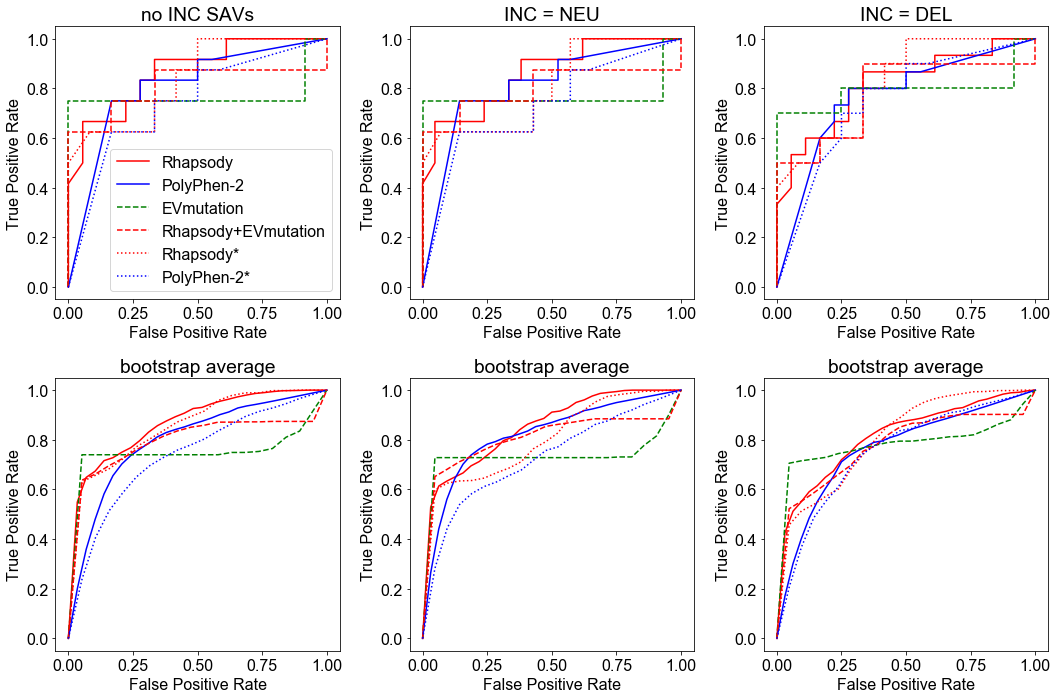

In [12]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16, 'font.family': 'Arial'})

legend = {
    'R_sl':   ('Rhapsody', '-', 'red'),
    'R+E_sl': ('Rhapsody+EVmutation', '--', 'red'),
    'PP2':    ('PolyPhen-2', '-', 'blue'),
    'EVmut':  ('EVmutation', '--', 'green'),
    'R_sl*':  ('Rhapsody*', ':', 'red'),
    'PP2*':   ('PolyPhen-2*', ':', 'blue')
}

fig, axes = plt.subplots(2, 3, figsize=(15,10))

for INC_label in [-1, 0, 1]:
    ax0 = axes[0, INC_label + 1]
    ax1 = axes[1, INC_label + 1]
    
    if INC_label == -1:
        ax0.set_title('no INC SAVs')
    elif INC_label == 0:
        ax0.set_title('INC = NEU')
    else:
        ax0.set_title('INC = DEL')
    ax1.set_title('bootstrap average')
    
    for method in ['R_sl', 'PP2', 'EVmut', 'R+E_sl', 'R_sl*', 'PP2*']:
        l = legend[method]
        metr = metrics[INC_label][method]
        ax0.plot(metr['ROC']['FPR'], metr['ROC']['TPR'],
                 ls=l[1], c=l[2], label=l[0])
        ax1.plot(metr['mean ROC']['FPR'], metr['mean ROC']['TPR'],
                 ls=l[1], c=l[2], label=l[0])

for ax in axes.flatten():
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
axes[0, 0].legend()

fig.tight_layout()
fig.savefig('local/ROCs.png', dpi=300)

In [13]:
EVmut_cutoff = -rd.getSettings(print=False)['EVmutation_metrics']['optimal cutoff']

In [14]:
# positive control SAVs
CTRL_SAVs = df[df['group'] == '0']

# SAVs with both Rhapsody and EVmutation predictions
subset = df[~np.isnan(df['EVmut score'])]
subset = subset[subset['group'] != '0']
DEL_SAVs = subset[subset['exp. fitness'] == 'DEL']
INT_SAVs = subset[subset['exp. fitness'] == 'INT']
NEU_SAVs = subset[subset['exp. fitness'] == 'NEU']

# SAVs without EVmutation predictions
subset = df[np.isnan(df['EVmut score'])]
subset = subset[subset['group'] !=0 ]
DEL_SAVs_rh = subset[subset['exp. fitness'] == 'DEL']
INT_SAVs_rh = subset[subset['exp. fitness'] == 'INT']
NEU_SAVs_rh = subset[subset['exp. fitness'] == 'NEU']
INC_SAVs_rh = subset[subset['exp. fitness'] == 'INC']

In [15]:
EVmut_score = rh_ref_classic.getPredictions()['EVmutation score']
PP2_score = rh_ref_classic.getPredictions()['PolyPhen-2 score']
rhapsody_pprob = rh_ref_classic.getPredictions()['path. prob.']

from scipy.stats import spearmanr

sel = ~np.isnan(EVmut_score)
rho_EVm = spearmanr(rhapsody_pprob[sel], EVmut_score[sel])

sel = ~np.isnan(rhapsody_pprob)
rho_PP2 = spearmanr(rhapsody_pprob[sel], PP2_score[sel])

print(f'Spearman corr. with EVmutation: {rho_EVm[0]:5.3f}')
print(f'Spearman corr. with PolyPhen-2: {rho_PP2[0]:5.3f}')

Spearman corr. with EVmutation: -0.668
Spearman corr. with PolyPhen-2: 0.782


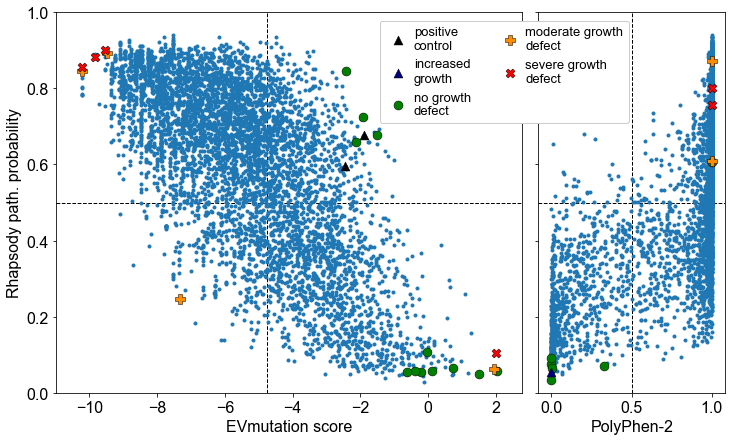

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12,7),
                         gridspec_kw={'width_ratios': [10, 4]})
plt.subplots_adjust(wspace=0.05)

ax1, ax2 = axes
ax1.scatter(EVmut_score, rhapsody_pprob, marker='.')
ax1.axvline(EVmut_cutoff, color='k', linestyle='--', lw=1, zorder=0)
ax1.axhline(0.5, color='k', linestyle='--', lw=1, zorder=0)

ax1.set_ylim((0,1))
ax1.set_xlabel('EVmutation score')
ax1.set_ylabel('Rhapsody path. probability')

ax1.scatter(CTRL_SAVs['EVmut score'], CTRL_SAVs['R_sl score'], s=80, color='k',  marker='^',
            label='positive\ncontrol', linewidths=.5, edgecolors='k')
ax1.scatter(NEU_SAVs['EVmut score'], NEU_SAVs['R_sl score'], s=80, color='green',  marker='o',
            label='no growth\ndefect', linewidths=.5, edgecolors='k')
ax1.scatter(INT_SAVs['EVmut score'], INT_SAVs['R_sl score'], s=100, color='darkorange', marker='P',
            label='moderate growth\ndefect', linewidths=.5, edgecolors='k')
ax1.scatter(DEL_SAVs['EVmut score'], DEL_SAVs['R_sl score'], s=80, color='red',    marker='X',
            label='severe growth\ndefect', linewidths=.5, edgecolors='k')

ax2.set_ylim((0,1))
ax2.set_xlabel('PolyPhen-2')
ax2.set_yticklabels([])

ax2.axhline(0.5, color='k', linestyle='--', lw=1, zorder=0)
ax2.axvline(0.5, color='k', linestyle='--', lw=1, zorder=0)
ax2.scatter(PP2_score, rhapsody_pprob, marker='.')
ax2.scatter(NEU_SAVs_rh['PP2 score'], NEU_SAVs_rh['R_sl score'], s=80,
            color='green', marker='o', label='NEU',
            linewidths=.5, edgecolors='k')
ax2.scatter(INC_SAVs_rh['PP2 score'], INC_SAVs_rh['R_sl score'], s=80,
            color='navy', marker='^', label='increased\ngrowth',
            linewidths=.5, edgecolors='k')
ax2.scatter(INT_SAVs_rh['PP2 score'], INT_SAVs_rh['R_sl score'], s=100,
            color='darkorange', marker='P', label='INT',
            linewidths=.5, edgecolors='k')
ax2.scatter(DEL_SAVs_rh['PP2 score'], DEL_SAVs_rh['R_sl score'], s=80,
            color='red', marker='X', label='DEL',
            linewidths=.5, edgecolors='k')

handles = ax1.get_legend_handles_labels()[0]
labels = ax1.get_legend_handles_labels()[1]
handles.insert(1, ax2.get_legend_handles_labels()[0][1])
labels.insert(1, ax2.get_legend_handles_labels()[1][1])
ax1.set_zorder(1)
ax1.legend(handles, labels, fontsize=13, handletextpad=0.2,
           ncol=2, loc=(0.695, 0.71), framealpha=1.0)

plt.savefig('local/scatter_plot-classic.png', dpi=300)

In [17]:
EVmut_score = rh_ref_EVmut.getPredictions()['EVmutation score']
rhapsody_pprob = rh_ref_EVmut.getPredictions()['path. prob.']

from scipy.stats import spearmanr

sel = ~np.isnan(rhapsody_pprob)
rho = spearmanr(rhapsody_pprob[sel], EVmut_score[sel])

print(f'Spearman corr. Rhapsody+EVmut. vs EVmutation: {rho[0]:5.3f}')

Spearman corr. Rhapsody+EVmut. vs EVmutation: -0.864


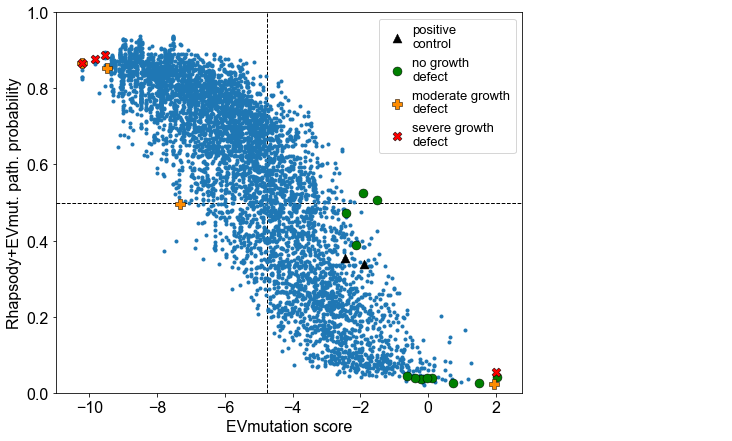

In [18]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16, 'font.family': 'Arial'})

fig, axes = plt.subplots(1, 2, figsize=(12,7),
                         gridspec_kw={'width_ratios': [10, 4]})
plt.subplots_adjust(wspace=0.05)

ax1, ax2 = axes
ax1.scatter(EVmut_score, rhapsody_pprob, marker='.')
ax1.axvline(EVmut_cutoff, color='k', linestyle='--', lw=1, zorder=0)
ax1.axhline(0.5, color='k', linestyle='--', lw=1, zorder=0)

ax1.set_ylim((0,1))
ax1.set_xlabel('EVmutation score')
ax1.set_ylabel('Rhapsody+EVmut. path. probability')

ax1.scatter(CTRL_SAVs['EVmut score'], CTRL_SAVs['R+E_sl score'], s=80, color='k', marker='^',
            label='positive\ncontrol', linewidths=.5, edgecolors='k')
ax1.scatter(NEU_SAVs['EVmut score'], NEU_SAVs['R+E_sl score'], s=80, color='green', marker='o',
            label='no growth\ndefect', linewidths=.5, edgecolors='k')
ax1.scatter(INT_SAVs['EVmut score'], INT_SAVs['R+E_sl score'], s=100, color='darkorange', marker='P',
            label='moderate growth\ndefect', linewidths=.5, edgecolors='k')
ax1.scatter(DEL_SAVs['EVmut score'], DEL_SAVs['R+E_sl score'], s=80, color='red', marker='X',
            label='severe growth\ndefect', linewidths=.5, edgecolors='k')

ax1.legend(fontsize=13, handletextpad=0.2)

ax2.axis('off')

plt.savefig('local/scatter_plot-EVmut.png', dpi=300)

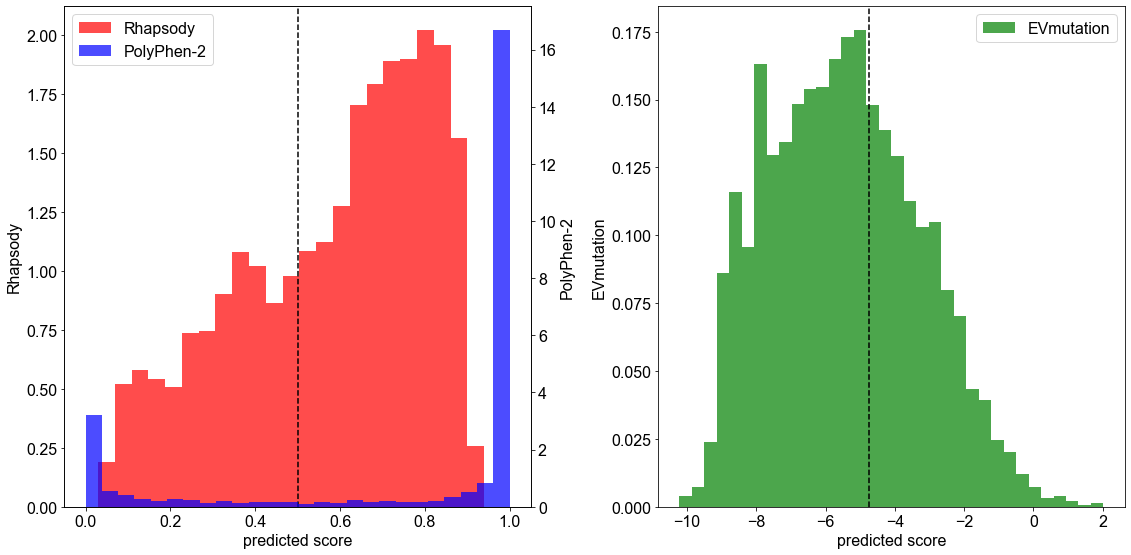

In [19]:
EVmut_score = rh_ref_classic.getPredictions()['EVmutation score']
EVmut_score = EVmut_score[~np.isnan(EVmut_score)]
rhapsody_pprob = rh_ref_classic.getPredictions()['path. prob.']
rhapsody_pprob = rhapsody_pprob[~np.isnan(rhapsody_pprob)]
PP2_score = rh_ref_classic.getPredictions()['PolyPhen-2 score']

fig, axes = plt.subplots(1, 2, figsize=(16,8))

ax = axes[0]
ax2 = ax.twinx()
ax.hist(rhapsody_pprob, density=True, bins='auto',
        color='red', alpha=.7, label='Rhapsody')
ax2.hist(PP2_score, density=True, bins='auto',
         color='blue', alpha=.7, label='PolyPhen-2')
ax.axvline(x=.5, ls='--', color='k')
ax.set_xlabel('predicted score')
ax.set_ylabel('Rhapsody')
ax2.set_ylabel('PolyPhen-2')

handles = ax.get_legend_handles_labels()[0]
labels = ax.get_legend_handles_labels()[1]
handles.extend(ax2.get_legend_handles_labels()[0])
labels.extend(ax2.get_legend_handles_labels()[1])
ax.legend(handles, labels)

axr = axes[1]
axr.hist(EVmut_score, density=True, bins='auto',
         color='green', alpha=.7, label='EVmutation')
axr.set_ylabel('EVmutation')
axr.set_xlabel('predicted score')
axr.axvline(x=EVmut_cutoff, ls='--', color='k')
axr.legend()

fig.tight_layout()
fig.savefig('local/distributions.png', dpi=300)

/home/luca/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice


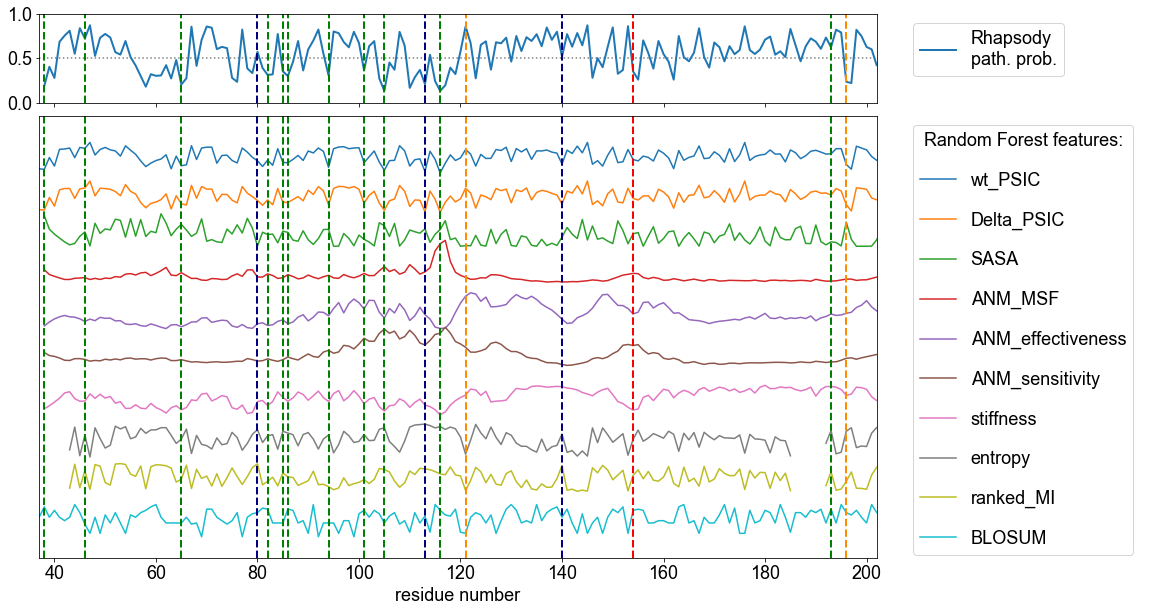

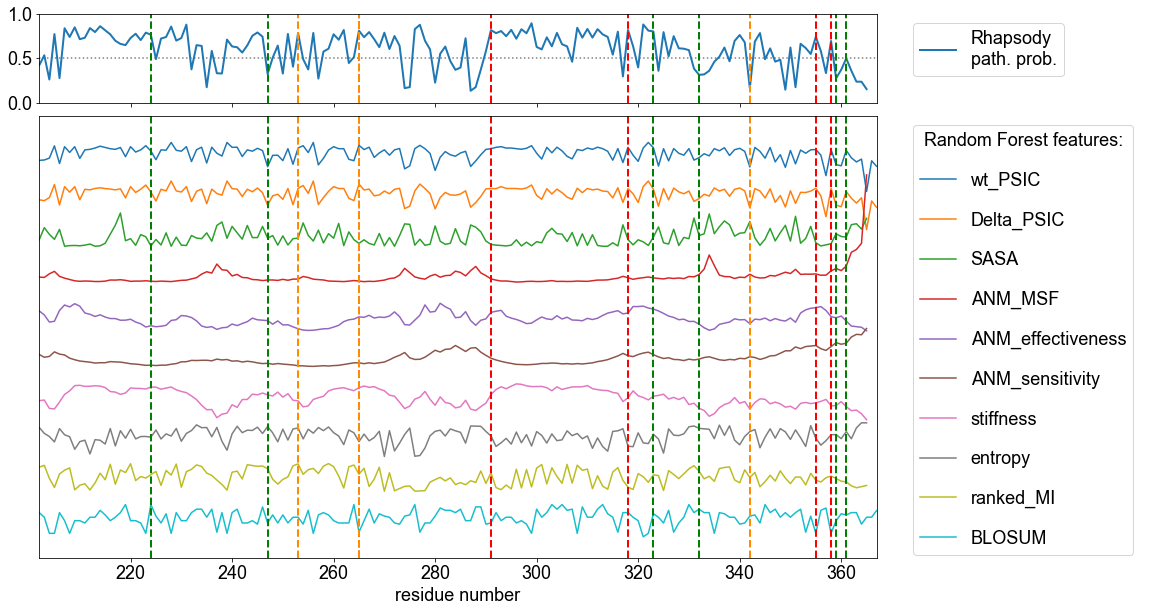

In [20]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18, 'font.family': 'Arial'})

seq_pos = rh_ref_classic.getUniqueSAVcoords()['position']
seq_pos = seq_pos.reshape((-1, 19))
seq_pos = seq_pos[:,0]

resavg_pprob = rh_ref_classic.getResAvgPredictions()['path. prob.']

for rng in [(37,202), (202, 367)]:
    fig, axes = plt.subplots(
        2, 2, figsize=(20,10), 
        gridspec_kw={'width_ratios': [10, 3], 'height_ratios': [2, 10]})
    plt.subplots_adjust(wspace=0.05)
    plt.subplots_adjust(hspace=0.05)

    ax_pp = axes[0,0]
    axes[0,1].axis('off')
    ax = axes[1,0]
    ax_leg = axes[1,1]
    ax_leg.axis('off')

    ax_pp.axhline(y=.5, color='gray', ls=':', zorder=0)
    ax_pp.plot(seq_pos, resavg_pprob, lw=2, label='Rhapsody\npath. prob.')
    ax_pp.set_xlim(rng)
    ax_pp.set_ylim((0, 1))
    ax_pp.set_xticklabels([])
    handles = ax_pp.get_legend_handles_labels()[0]
    labels = ax_pp.get_legend_handles_labels()[1]
    axes[0,1].legend(handles, labels, loc='upper left')

    for i,f in enumerate(rh_ref_classic.featSet):
        f_arr = rh_ref_classic.featMatrix[:,i]
        # residue-average
        f_mtx = f_arr.reshape((-1, 19))
        f_resavg = np.nanmean(f_mtx, axis=1)
        # normalize
        f_resavg -= np.nanmean(f_resavg)
        f_resavg /= 5*np.nanstd(f_resavg)
        # plot
        ax.plot(seq_pos, f_resavg + 9 - i, label=f.replace('-sliced', ''))

    ax.set_ylim((-1, 10))
    ax.set_xlim(rng)
    ax.set_xlabel('residue number')
    ax.set_yticks([])

    handles = ax.get_legend_handles_labels()[0]
    labels = ax.get_legend_handles_labels()[1]
    ax_leg.legend(handles, labels, title="Random Forest features:",
                  loc='upper left', labelspacing=1.2)

    for i, row in df.iterrows():
        pos = int(row['oSAV'].split()[1])
        phenotype = row['exp. fitness']
        if phenotype == 'INC':
            if row['group'] == 0:
                color = 'black'
            else:
                color = 'navy'
        elif phenotype == 'NEU':
            color = 'green'
        elif phenotype == 'INT':
            color = 'darkorange'
        else:
            assert phenotype == 'DEL'
            color = 'red'
        ax_pp.axvline(x=pos, ls='--', lw=2, color=color)
        ax.axvline(x=pos, ls='--', lw=2, color=color)

    plt.savefig('local/features-{}_{}.png'.format(*rng), dpi=300)